<a href="https://colab.research.google.com/github/igorvojnyak/datavojnyak.github.io/blob/master/A/B%20testing%20Facebook%20advertisement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as st
import statsmodels.stats.api as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/ab_data.csv')
df.head()

In [3]:
print("number of rows ", df.shape[0], "number of columns ", df.shape[1])

number of rows  294478 number of columns  5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [14]:
df["group"].value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

In [15]:
print(df["user_id"].count())
print(df["user_id"].nunique())

290584
290584


In [0]:
df.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [6]:
(len(df.query('converted == 1'))/df['user_id'].nunique())

0.12126269856564711

In [7]:
ab_test = df.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_test['total'] = df.pivot_table(values='converted', index='group', aggfunc=lambda x:len(x))
ab_test['rate'] = df.pivot_table(values='converted', index='group')
ab_test

,converted,total,rate
group,,,
control,17723,147202,0.120399
treatment,17514,147276,0.118920


In [0]:
mask1 = (df["group"] =="control") & (df["landing_page"] =="new_page")
index_to_drop1 = df[mask1].index
df = df.drop(index_to_drop1)

mask2 = (df["group"] == "treatment") & (df["landing_page"] == "old_page")
index_to_drop2 = df[mask2].index
df = df.drop(index_to_drop2)

In [0]:
#Calculate pooled probability
mask = (df["group"] == "control")
conversions_control = df["converted"][mask].sum()
total_users_control = df["converted"][mask].count()

mask = (df["group"] == "treatment")
conversions_treatment = df["converted"][mask].sum()
total_users_treatment = df["converted"][mask].count()

prob_pooled = (conversions_control + conversions_treatment) / (total_users_control + total_users_treatment)


In [13]:
baseline_rate = conversions_control / total_users_control
practical_significance = 0.01 #user defined
confidence_level = 0.05 #user defined, for a 95% confidence interval
sensitivity = 0.8 #user defined

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  17209  per group


In [0]:
#Calculate pooled probability
mask = (df["group"] == "control")
conversions_control = df["converted"][mask].sum()
total_users_control = df["converted"][mask].count()

mask = (df["group"] == "treatment")
conversions_treatment = df["converted"][mask].sum()
total_users_treatment = df["converted"][mask].count()

prob_pooled = (conversions_control + conversions_treatment) / (total_users_control + total_users_treatment)


In [17]:
prob_pooled

0.11959708724499628

In [19]:
print("Split of control users who saw old page vs treatment users who saw new page: ", 
          round(total_users_control / df["converted"].count() * 100, 2), "% ",
          round((total_users_treatment / df["converted"].count()) * 100, 2), "%")

#count number of users who converted in each group
print("Number of control users who converted on old page: ", conversions_control)
print("Percentage of control users who converted: ", round((conversions_control / total_users_control) * 100, 2), "%")

mask = (df["group"] == "treatment")
print("Number of treatment users who converted on new page: ", conversions_treatment)
print("Percentage of treatment users who converted: ", round((conversions_treatment/ total_users_treatment) * 100, 2), "%")

Split of control users who saw old page vs treatment users who saw new page:  49.99 %  50.01 %
Number of control users who converted on old page:  17489
Percentage of control users who converted:  12.04 %
Number of treatment users who converted on new page:  17264
Percentage of treatment users who converted:  11.88 %


In [20]:

#Check what sample size is required
baseline_rate = conversions_control / total_users_control
practical_significance = 0.01 #user defined
confidence_level = 0.05 #user defined, for a 95% confidence interval
sensitivity = 0.8 #user defined

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  17209  per group


In [0]:
#Calculate pooled probability
mask = (df["group"] == "control")
conversions_control = df["converted"][mask].sum()
total_users_control = df["converted"][mask].count()

mask = (df["group"] == "treatment")
conversions_treatment = df["converted"][mask].sum()
total_users_treatment = df["converted"][mask].count()

prob_pooled = (conversions_control + conversions_treatment) / (total_users_control + total_users_treatment)

In [24]:
#Calculate pooled standard error and margin of error
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / total_users_control + 1 / total_users_treatment))
z_score = st.norm.ppf(1 - confidence_level / 2)
margin_of_error = se_pooled * z_score

#Calculate dhat, the estimated difference between probability of conversions in the experiment and control groups
d_hat = (conversions_treatment / total_users_treatment) - (conversions_control / total_users_control)

#Test if we can reject the null hypothesis
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

if practical_significance < lower_bound:
    print("Reject null hypothesis")
else: 
    print("Do not reject the null hypothesis")
    
print("The lower bound of the confidence interval is ", round(lower_bound * 100, 2), "%")
print("The upper bound of the confidence interval is ", round(upper_bound * 100, 2), "%")

Do not reject the null hypothesis
The lower bound of the confidence interval is  -0.39 %
The upper bound of the confidence interval is  0.08 %


In [45]:
lower_bound

-0.003937865555689694

In [46]:
upper_bound

0.0007813875849785809

In [0]:
df2 = df.query('(group == "treatment" & landing_page == "new_page") or (group == "control" & landing_page == "old_page")')

In [26]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [0]:
real_old = len(df2.query('group == "control" & converted == 1'))/len(df2.query('group == "control"'))
real_new = len(df2.query('group == "treatment" & converted == 1'))/len(df2.query('group == "treatment"'))

In [0]:
real_diff = real_new - real_old

In [0]:
p_new = len(df.query('converted == 1'))/len(df)
p_old = p_new

In [32]:
n_new = df.query('group == "treatment" and landing_page == "new_page"').nunique()[0]
print(n_new)

145310


In [33]:
n_old = df.query('group == "control" and landing_page == "old_page"').nunique()[0]
print(n_old)

145274


In [0]:
new_page_converted = np.random.binomial(1, p_new, n_new)
old_page_converted = np.random.binomial(1, p_old, n_old)

In [47]:

len(df2.query('landing_page == "new_page"'))/len(df2)

0.5000619442226688

In [0]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

-0.0015782389853555567


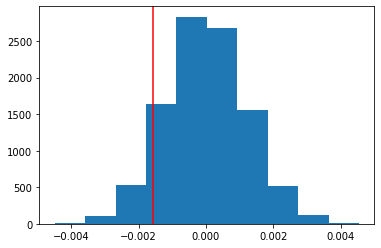

In [48]:
print(real_diff)
plt.hist(p_diffs)
plt.axvline(x = real_diff,color = 'red');

In [49]:
p_diffs = np.array(p_diffs)
(p_diffs > real_diff).mean()

0.9104

In [50]:
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df.query('landing_page == "old_page"'))
n_new = len(df.query('landing_page == "new_page"'))
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [61]:

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [64]:
print(norm.cdf(z_score))
print(norm.ppf(1-(0.05/2)))

0.9050583127590245
1.959963984540054
